In [17]:
import random
import json
import pickle
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Bidirectional, LSTM, Input, Attention, Flatten, Concatenate  
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import gensim.models
import matplotlib.pyplot as plt

In [18]:
lemmatizer = WordNetLemmatizer()

In [19]:
w2v_model = gensim.models.Word2Vec.load("data/output/gram.model")

In [20]:

intents = json.loads(open('data/input/intents.json').read())

In [21]:
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

In [22]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [23]:
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))

classes = sorted(set(classes))

In [24]:
pickle.dump(words, open('data/output/Attention/words.pkl', 'wb'))
pickle.dump(classes, open('data/output/Attention/classes.pkl', 'wb'))


In [25]:
training = []
output_empty = [0] * len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)

In [26]:
# Separate train_x and train_y
train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

In [27]:
input_layer = Input(shape=(len(train_x[0]),))
embedding_layer = Embedding(input_dim=len(words), output_dim=100)(input_layer)
lstm_layer = Bidirectional(LSTM(130, return_sequences=True))(embedding_layer)
attention1 = Attention()([lstm_layer, lstm_layer])
attention1 = Flatten()(attention1)
lstm_layer2 = Bidirectional(LSTM(130, return_sequences=True))(lstm_layer)
attention2 = Attention()([lstm_layer2, lstm_layer2])
attention2 = Flatten()(attention2)
concatenated_attention = Concatenate()([attention1, attention2])
output_layer = Dense(len(train_y[0]), activation='softmax')(concatenated_attention)

model = Model(inputs=[input_layer], outputs=[output_layer])

In [28]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [29]:
early_stopping = EarlyStopping(monitor='accuracy', patience=60, verbose=1)
history = model.fit(train_x, train_y, epochs=1500, batch_size=16, verbose=1, callbacks=[early_stopping])


Epoch 1/1500


/home/misti-rani/Desktop/Projects/Mayabati---Your-Personal-AI-Chef/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(None, 143))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - accuracy: 0.1627 - loss: 2.3538
Epoch 2/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.2264 - loss: 2.1799
Epoch 3/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - accuracy: 0.2262 - loss: 2.1944
Epoch 4/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step - accuracy: 0.2049 - loss: 2.2140
Epoch 5/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - accuracy: 0.1869 - loss: 2.1706
Epoch 6/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 0.2348 - loss: 2.1331
Epoch 7/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 0.1955 - loss: 2.2114
Epoch 8/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.2005 - loss: 2.1355
Epoch 9/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - accuracy: 0.2324 - loss: 2.1636
Epoch 10/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 0.1986 - loss: 2.2085
Epoch 11/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 0.1770 - loss: 2.1111
Epoch 12/1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - accuracy: 

In [30]:
# Save the model
model.save('data/output/Attention/Rasika.keras')

In [31]:
# Print "Done"
print("Done")

Done


In [32]:
# Plot training history
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

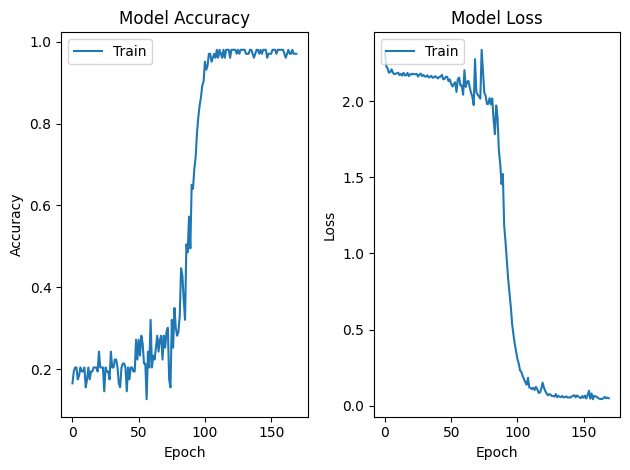

In [33]:
# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

# Show plots
plt.tight_layout()
plt.show()
